## Step 1: Import Required Libraries

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\s\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



## Step 2: Load the Dataset


In [70]:
data = pd.read_csv("Emails.csv", encoding='latin1')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


## Step 3: Balance the Dataset

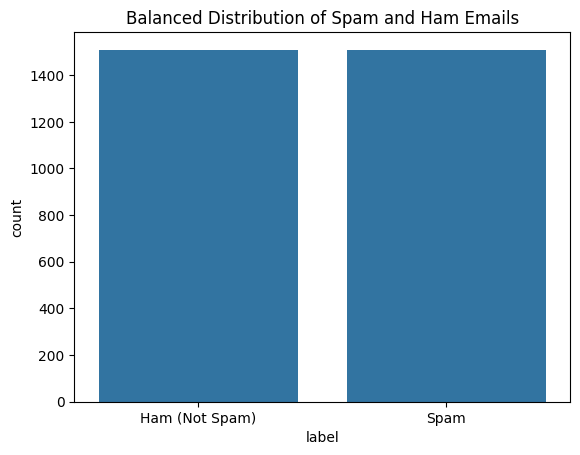

In [71]:
ham_msg = data[data['label'] == 'ham']
spam_msg = data[data['label'] == 'spam']

# Downsample Ham emails to match the number of Spam emails
ham_msg_balanced = ham_msg.sample(n=len(spam_msg), random_state=42)

# Combine balanced data
balanced_data = pd.concat([ham_msg_balanced, spam_msg]).reset_index(drop=True)

# Visualize the balanced dataset
sns.countplot(x='label', data=balanced_data)
plt.title("Balanced Distribution of Spam and Ham Emails")
plt.xticks(ticks=[0, 1], labels=['Ham (Not Spam)', 'Spam'])
plt.show()

## Step 4: Clean the Text

In [72]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,1913,ham,: rockets schedule\r\nthe schedule is attached...,0
1,1226,ham,": enron / hpl actuals for july 21 , 2000\r\n( ...",0
2,1225,ham,": re : cornhusker\r\njohn ,\r\ni did some prel...",0
3,2984,ham,: re : feb 01 prod : sale to teco gas processi...,0
4,1449,ham,: final cp name change / merger list 08 / 00\r...,0


In [73]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,1913,ham,rockets schedule\r\nthe schedule is attached ...,0
1,1226,ham,enron hpl actuals for july 21 2000\r\n see ...,0
2,1225,ham,re cornhusker\r\njohn \r\ni did some prelimi...,0
3,2984,ham,re feb 01 prod sale to teco gas processing\...,0
4,1449,ham,final cp name change merger list 08 00\r\na...,0


In [74]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,1913,ham,rockets schedule schedule attached remind days...,0
1,1226,ham,enron hpl actuals july 21 2000 see attached fi...,0
2,1225,ham,cornhusker john preliminary work question conc...,0
3,2984,ham,feb 01 prod sale teco gas processing deal febr...,0
4,1449,ham,final cp name change merger list 08 00 attache...,0


In [75]:
import re

def preprocess_email(text):
    text = text.lower()
    # Replace money patterns like "$100", "$50.00"
    text = re.sub(r'\$\d+(\.\d+)?', 'moneytoken', text)
    # Replace $ symbol itself (if not followed by numbers)
    text = text.replace('$', ' money ')
    return text


balanced_data['text'] = balanced_data['text'].apply(preprocess_email)

## 

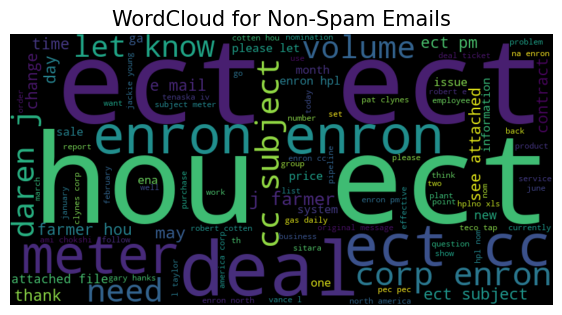

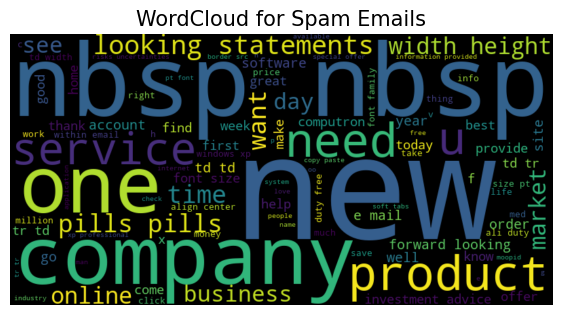

In [76]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} Emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['label'] == 'ham'], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label'] == 'spam'], typ='Spam')

## Step 6: Tokenization and Padding

In [77]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import pickle

# 1️⃣ Split the dataset
train_X, test_X, train_Y, test_Y = train_test_split(
    balanced_data['text'], balanced_data['label'], test_size=0.2, random_state=42
)

# 2️⃣ Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# 3️⃣ Pad sequences to fixed length
max_len = 100
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

# Convert labels to 0/1
train_Y = (train_Y == 'spam').astype(int)
test_Y = (test_Y == 'spam').astype(int)

## Step 7: Define the Model

In [78]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# ❗ Fixed: from_logits=False (because of sigmoid)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

model.build(input_shape=(None, max_len))
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 100, 32)        │     1,291,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,295,073 (4.94 MB)

 Trainable params: 1,295,073 (4.94 MB)

 Non-trainable params: 0 (0.00 B)

## Step 8: Train the Model

In [79]:
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(
    train_sequences, train_Y,
    validation_data=(test_sequences, test_Y),
    epochs=20,
    batch_size=32,
    callbacks=[lr, es]
)

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.6781 - loss: 0.6021 - val_accuracy: 0.9073 - val_loss: 0.2899 - learning_rate: 0.0010
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9528 - loss: 0.1793 - val_accuracy: 0.9520 - val_loss: 0.1733 - learning_rate: 0.0010
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9743 - loss: 0.1211 - val_accuracy: 0.9536 - val_loss: 0.1855 - learning_rate: 0.0010
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9818 - loss: 0.0910 - val_accuracy: 0.9652 - val_loss: 0.1447 - learning_rate: 0.0010
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9764 - loss: 0.1286 - val_accuracy: 0.9305 - val_loss: 0.2865 - learning_rate: 0.0010
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9648 - loss: 0.1459 - val_accuracy: 0.9454 - val_loss: 0.2039 - learning_rate: 0.0010
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9664 - loss: 0.1449 - val_acc

In [80]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9652 - loss: 0.1447
Test Loss : 0.14472244679927826
Test Accuracy : 0.9652317762374878


In [81]:
new_email = ["Subject: You won $10,000! Congratulations! You have been selected as the lucky winner of our cash prize. Click here to claim your reward: http://bit.ly/win-money"]

# Convert to sequence
new_seq = tokenizer.texts_to_sequences(new_email)
new_seq = pad_sequences(new_seq, maxlen=max_len, padding='post', truncating='post')

# Predict probability
pred_prob = model.predict(new_seq)[0][0]

# Apply threshold
if pred_prob > 0.4:
    result = "SPAM 🚫"
else:
    result = "NOT SPAM ✅"

print(f"Spam Probability: {pred_prob:.2f}")
print("Prediction:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Spam Probability: 0.97
Prediction: SPAM 🚫


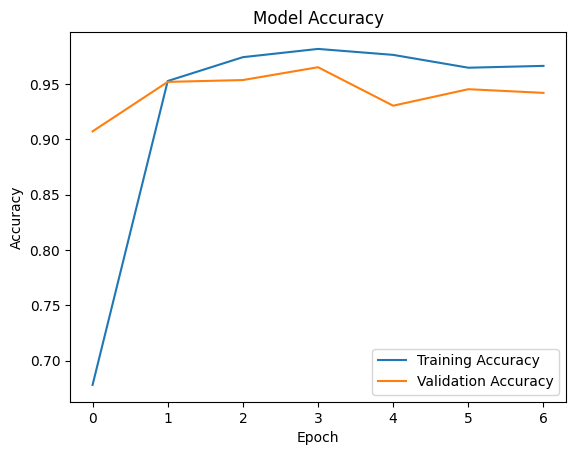

In [82]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Step 9: Save Model (inside spam_email.ipynb)

In [83]:
# Save the model
model.save('spam_model.h5')

# Save the tokenizer
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("✅ Model and tokenizer saved successfully!")


✅ Model and tokenizer saved successfully!
